## Load model

In [1]:
import sys
sys.path.append('yolov7_bbox')
from face_alignment import *
import yaml
import torch
from yolov7_bbox.models2.yolo import Model
from yolov7_bbox.bbox_detection import detect as bbox_detect

import sys
sys.path.append('yolov7_bbox_landmarks')

from yolov7_bbox_landmarks.models.experimental import attempt_load
from yolov7_bbox_landmarks.kpts_detection import detect as kpt_detect

import iresnet
import torch
from torch import nn
import shutil

import cv2
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import clip

@torch.no_grad()
def inference(net, img):
    if img is None:
        img = np.random.randint(0, 255, size=(112, 112, 3), dtype=np.uint8)
    else:
        img = cv2.resize(img, (112, 112))

    img = np.transpose(img, (2, 0, 1))
    img = torch.from_numpy(img.copy()).unsqueeze(0).float()
    img.div_(255).sub_(0.5).div_(0.5)
    net.eval()
    with torch.no_grad():
        feat = net(img.to('cuda'))
    return feat

def save_yaml(data, file_path):
    with open(file_path, 'w') as file:
        yaml.dump(data, file)

def load_yaml(file_path):
    with open(file_path, 'r') as file:
        data = yaml.safe_load(file)
    return data

def pet_face_detector(img_path):
    img = cv2.imread(img_path)
    imgs = []
    _, bbox_list, src_pts_list, conf = kpt_detect(yolo_model1, img_path, device)
    _, bbox_list2, conf2 = bbox_detect(yolo_model2, img_path, device)
    if src_pts_list and bbox_list:
        for i, (bbox, s) in enumerate(zip(bbox_list, src_pts_list)):
            src_pts = adjust_src_pts(np.array(s).reshape(3, 2))
            face_img = preprocess(img, bbox, src_pts, image_size="112, 112", margin=0)
            imgs.append(face_img)
    elif bbox_list2:
        for i, bbox in enumerate(bbox_list2):
            crop_img = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
            imgs.append(crop_img)
    return imgs


In [2]:
file_path = 'yolov7_bbox/yolo_model2_yaml.yaml'
yolo_model2_yaml = load_yaml(file_path)

weights = 'yolov7_bbox/weights/yolov7x-pet-face.pth'
state_dict = torch.load(weights)
state_dict = {key[6:]: value for key, value in state_dict.items()}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
yolo_model2 = Model(yolo_model2_yaml).to(device)
yolo_model2.load_state_dict(state_dict)
yolo_model2.autoshape()
print(device)

Adding autoShape... 
cuda


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
weights = 'yolov7_bbox_landmarks/weights/yolov7-pet-face.pt'
yolo_model1 = attempt_load(weights, map_location=device)

In [4]:
clip.available_models()
device = "cuda" if torch.cuda.is_available() else 'cpu'
clip_model, clip_preprocess = clip.load("ViT-B/16")

In [5]:
model_path = 'best_data25_2024_12_31.pth'
device = 'cuda'
backbone = iresnet.iresnet100(num_classes=512)
backbone.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
backbone.to(device)
device

'cuda'

In [6]:
from PIL import Image

def clip_clf(img, text, model=clip_model):
    image = clip_preprocess(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        I_f = model.encode_image(image)
        T_f = model.encode_text(text)

    logits_I, logits_T = model(image, text)
    probs = logits_I.softmax(dim=-1).detach().cpu().numpy()

    return probs

text_pool = [
    "it is an image of a dog",
    "it is an image of a cat",
    "it is an image of a pet",
    "it is a cartoon cat image",
    "it is a cartoon dog image",
    "it is a background image",
    "it is an image of human",
    "it is an advertisement",
]

text = clip.tokenize(text_pool).to(device)

## Move into the raw folder

- Chinese folder name as description

In [12]:
src = 'UM_貓面識別相片'
dst = 'UM_cat_dataset/um_cat_raw'

start_num = len(os.listdir(dst))
end_num = len(os.listdir(src)) + start_num

data = []
for num, folder in enumerate(os.listdir(src), start_num):
    os.makedirs(f'{dst}/{num}', exist_ok=True)
    for img_name in os.listdir(f'{src}/{folder}'):
        img_num = len(os.listdir(f'{dst}/{num}'))
        raw_img_path = f'{dst}/{num}/{img_num}.jpg'
        shutil.copy(f'{src}/{folder}/{img_name}', raw_img_path)
        data.append([num, raw_img_path, folder])


In [13]:
import pandas as pd

cols = ['raw_id', 'raw_img_path', 'description']

df_um_cat = pd.DataFrame(data, columns=cols)

In [14]:
df_um_cat

,raw_id,raw_img_paht,description
0,34,UM_cat_dataset/um_cat_raw/34/0.jpg,教育學院門前 貓7
1,34,UM_cat_dataset/um_cat_raw/34/1.jpg,教育學院門前 貓7
2,35,UM_cat_dataset/um_cat_raw/35/0.jpg,教育學院門前 貓8


## Pet Face Detection and Face Alignment

- Two stages YOLOv7 detector
- Face Alignment
- CLIP Filtering

In [15]:
dst = 'UM_cat_dataset/um_cat_alignment'

cos = nn.CosineSimilarity(eps=1e-6).to(device)

img = cv2.imread('logo.jpg')
logo_emb = inference(backbone, img[..., ::-1])

for record in df_um_cat.values:
    raw_id, raw_img_path, des = record
    os.makedirs(f'{dst}/{raw_id}', exist_ok=True)
    imgs = pet_face_detector(raw_img_path)
    img_name = raw_img_path.split('/')[-1]
    
    for i, img in enumerate(imgs):
        emb = inference(backbone, img[..., ::-1])
        probs = clip_clf(Image.fromarray(img[...,::-1]), text)
        ind = np.argmax(probs)
        if cos(logo_emb, emb).item() < 0.3 and ind in [0, 1, 2]:
            cv2.imwrite(f'{dst}/{raw_id}/{i}_{img_name}', img)


image 1/1 D:\pet\UM_cat_dataset\um_cat_raw\34\0.jpg: tensor(0.92478, device='cuda:0')
Done: D:\pet\UM_cat_dataset\um_cat_raw\34\0.jpg
image 1/1 D:\pet\UM_cat_dataset\um_cat_raw\34\1.jpg: tensor(0.67461, device='cuda:0')
Done: D:\pet\UM_cat_dataset\um_cat_raw\34\1.jpg
image 1/1 D:\pet\UM_cat_dataset\um_cat_raw\35\0.jpg: tensor(0.91804, device='cuda:0')
Done: D:\pet\UM_cat_dataset\um_cat_raw\35\0.jpg


## Delete empty folder

In [16]:
for f in os.listdir(dst):
    if len(os.listdir(f'{dst}/{f}')) == 0:
        shutil.rmtree(f'{dst}/{f}')

## Graph spliting

In [73]:
df = pd.read_excel('UM_cat_dataset/um_cat_id_des.xlsx')
des_dict = dict(df.values)

In [28]:
src = 'UM_cat_dataset/um_cat_alignment'
dst = 'UM_cat_dataset/um_cat_alignment_split'

cos = nn.CosineSimilarity(eps=1e-6).to(device)

total_folder = len(os.listdir(src))

for num, record in enumerate(df_um_cat.values):
    folder = record[0]
    des = record[-1]
    for i, img_path in enumerate(os.listdir(f"{src}/{folder}")):
        img = cv2.imread(f"{src}/{folder}/{img_path}")[..., ::-1]
        emb = inference(backbone, img)
        embs = emb if i == 0 else torch.vstack((embs, emb))
    
    groups = []
    labels = np.array(os.listdir(f"{src}/{folder}"))
    while len(labels):
        max_score = 0
        for e in embs:
            cos_sim = cos(e.reshape(1, -1), embs)
            if cos_sim.sum().item() > max_score:
                max_score = cos_sim.sum().item()
                max_cos_sim = cos_sim

        threshold = 0.279
        mask = max_cos_sim.detach().cpu().numpy() < threshold
        groups.append(labels[~mask])
        embs = embs[mask]
        labels = labels[mask]
    
    for i, img_names in enumerate(groups):
        id_num = f'000{folder}'[-4:]
        dst_folder = f'{id_num}_{i}'
        des_dict[dst_folder] = des
        os.makedirs(f'{dst}/{dst_folder}', exist_ok=True)
        for img_name in img_names:
            shutil.copy(f"{src}/{folder}/{img_name}", f'{dst}/{dst_folder}/{id_num}_{img_name}')
    

## Merge Similar ID

In [109]:
src = 'UM_cat_dataset/um_cat_alignment_split'

cos = nn.CosineSimilarity(eps=1e-6).to(device)

img_paths = []
labels = []
for folder in os.listdir(src):
    for img_path in os.listdir(f"{src}/{folder}"):
        img_size = cv2.imread(f"{src}/{folder}/{img_path}").shape
        if img_size  == (112, 112, 3):
            img_paths.append(f"{src}/{folder}/{img_path}")
            labels.append(folder)
labels = np.array(labels)

for i, img_path in enumerate(img_paths):
    img = cv2.imread(img_path)
    emb = inference(backbone, img)
    embs = emb if i == 0 else torch.vstack((embs, emb))

sim_pairs = []
sim_pairs_scores = []

for l in np.unique(labels):
    embs1 = embs[labels == l]
    embs2 = embs[labels != l]
    for i, e in enumerate(embs1):
        cos_sim = cos(e.reshape(1, -1), embs2)
        cos_sims = cos_sim if i == 0 else torch.hstack((cos_sims, cos_sim))
        temp_label = labels[labels != l] if i == 0 else np.hstack((temp_label, labels[labels != l]))
    
    mask1 = (cos_sims > 0.69)
    inds = torch.argsort(cos_sims[mask1])
    most_sim_id_list = temp_label[mask1.cpu().numpy()][inds.cpu().numpy()]
    sim_scores = cos_sims[mask1][inds].cpu().numpy()

    if len(most_sim_id_list) == 0:
        continue
    
    pairs = sorted([l, most_sim_id_list[-1]])
    score = sim_scores[-1]
    if pairs not in sim_pairs:
        sim_pairs.append(pairs)
        sim_pairs_scores.append(score)


In [110]:
max_scores = {}

# 遍历sim_pairs和sim_pairs_scores
for pair, score in zip(sim_pairs, sim_pairs_scores):
    id1, id2 = pair
    current_max = max(max_scores.get(id1, 0), max_scores.get(id2, 0))
    
    # 如果当前分数大于之前的最大分数，则更新字典
    if score > current_max:
        max_scores[id1] = score
        max_scores[id2] = score

# 保留最大相似分数的记录
filtered_sim_pairs = [(id1, id2, score) for (id1, id2), score in zip(sim_pairs, sim_pairs_scores) if score == max_scores[id1]]

filtered_sim_pairs

[('0002_0', '0028_0', 0.7998497),
 ('0009_0_0033_1', '0028_0', 0.8363478),
 ('0027_0', '0033_0', 0.8515277),
 ('0029_0', '0031_0', 0.9094165)]

In [111]:
from ipywidgets import interact, Checkbox
from PIL import Image

%matplotlib inline

# 创建一个空的字典，用于存储用户的选择
user_selections = {}

# 定义一个函数，用于显示图片和 Checkbox，并更新用户选择的字典
def display_images(index):
    global user_selections
    
    qid, sid, score = filtered_sim_pairs[index]
    #score = sim_pairs_scores[index]
    des1 = des_dict[qid]#df[df['id'] == qid]['description'].values[0]
    des2 = des_dict[sid]#df[df['id'] == sid]['description'].values[0]
    print(f'{qid}: {des1}')
    print(f'{sid}: {des2}')
    
    plt.figure(figsize=(8, 3))
    total_size = len(os.listdir(f'{src}/{qid}')) + len(os.listdir(f'{src}/{sid}'))
    idx = 1
    
    for img_name in os.listdir(f'{src}/{qid}'):
        plt.subplot(1, total_size, idx)
        plt.imshow(Image.open(f'{src}/{qid}/{img_name}'))
        idx += 1
        plt.title(qid)
        plt.axis('off')
    
    for img_name in os.listdir(f'{src}/{sid}'):
        plt.subplot(1, total_size, idx)
        plt.imshow(Image.open(f'{src}/{sid}/{img_name}'))
        idx += 1
        plt.title(sid)
        plt.axis('off') 

    # 创建 Checkbox
    checkbox = Checkbox(value=False, description='Select')

    # 定义 Checkbox 变化时的回调函数
    def checkbox_changed(change):
        user_selections[(qid, sid)] = change.new

    # 将回调函数与 Checkbox 绑定
    checkbox.observe(checkbox_changed, names='value')

    # 显示 Checkbox
    display(checkbox)

    plt.suptitle(f'similarity of {qid} and {sid}: {round(score*100, 2)}%')
    plt.show()

# 使用 interact 函数，让用户选择相同的图片
interact(display_images, index=[i for i in range(len(filtered_sim_pairs))])


interactive(children=(Dropdown(description='index', options=(0, 1, 2, 3), value=0), Output()), _dom_classes=('…

<function __main__.display_images(index)>

In [62]:
for (qid, sid) in user_selections.keys():
    save_folder = f'{src}/{qid}_{sid}'
    
    if os.path.exists(save_folder):
        continue
    
    os.makedirs(save_folder)
        
    for img_name in os.listdir(f'{src}/{qid}'):
        shutil.move(f'{src}/{qid}/{img_name}', f'{save_folder}/{img_name}')
    
    for img_name in os.listdir(f'{src}/{sid}'):
        shutil.move(f'{src}/{sid}/{img_name}', f'{save_folder}/{img_name}')
    
    new_id = f'{qid}_{sid}'
    print(f'[INFO] {qid}, {sid} merge into {new_id}')
    
    des_dict[new_id] = f'{des_dict[qid]} {des_dict[sid]}'
    del des_dict[qid]
    del des_dict[sid]
    shutil.rmtree(f'{src}/{qid}')
    shutil.rmtree(f'{src}/{sid}')


[INFO] 0009_0, 0033_1 merge into 0009_0_0033_1


In [63]:
df = pd.DataFrame(des_dict.items(), columns=['id', 'description'])
df.to_excel('UM_cat_dataset/um_cat_id_des.xlsx', index=None)

## Visualization

In [112]:
df = pd.read_excel('UM_cat_dataset/um_cat_id_des.xlsx')

In [113]:
%matplotlib inline

src = 'UM_cat_dataset/um_cat_alignment_split'

max_img_size = max([len(os.listdir(f"{src}/{folder}")) for folder in os.listdir(src)])

for folder in os.listdir(src):
    plt.figure(figsize=(7, 2))
    for i, img_name in enumerate(os.listdir(f"{src}/{folder}")):
        img = cv2.imread(f"{src}/{folder}/{img_name}")
        plt.subplot(1, max_img_size, i + 1)
        plt.imshow(img[..., ::-1])
        plt.axis('off')
    
    des = df[df['id'] == folder]['description'].values[0]
    print(f'Description: {des}')
    plt.suptitle(f'ID: {folder}')
    plt.show()

## Matching

### database

In [7]:
df = pd.read_excel('UM_cat_dataset/um_cat_id_des.xlsx')

src = 'UM_cat_dataset/um_cat_alignment_split'

cos = nn.CosineSimilarity(eps=1e-6).to(device)

img_paths = []
labels = []
for folder in os.listdir(src):
    for img_path in os.listdir(f"{src}/{folder}"):
        img_size = cv2.imread(f"{src}/{folder}/{img_path}").shape
        if img_size  == (112, 112, 3):
            img_paths.append(f"{src}/{folder}/{img_path}")
            labels.append(folder)
labels = np.array(labels)

for i, img_path in enumerate(img_paths):
    img = cv2.imread(img_path)
    emb = inference(backbone, img)
    embs = emb if i == 0 else torch.vstack((embs, emb))


### query image

In [8]:
import json

def load_json(json_file_path):
    with open(json_file_path, 'r', encoding='utf-8') as json_file:
        # 使用 json.load() 方法加载 JSON 数据
        data = json.load(json_file)
    return data

In [9]:
def load_query_file(src):
    cos = nn.CosineSimilarity(eps=1e-6).to(device)

    test_embs = []
    test_imgs = []
    for img_name in os.listdir(src):
        if '.jpg' in img_name:
            img_path = f'{src}/{img_name}'
            imgs = pet_face_detector(img_path)
            for img in imgs:
                test_imgs.append(img)
                emb = inference(backbone, img[..., ::-1]).detach().cpu().numpy()
                test_embs.append(emb)
        elif '.json' in img_name:
            json_data = load_json(f'{src}/{img_name}')

    test_embs = torch.from_numpy(np.array(test_embs)).to(device)
    return test_embs, test_imgs, json_data

In [10]:
def matching_top_n(test_embs, test_imgs, n=5):
    y_pred = []
    y_cos = []

    for test_emb in test_embs:
        res = cos(test_emb, embs)
        y_cos += list(res.cpu().numpy())
        y_pred += list(labels)

    inds = np.argsort(y_cos)[::-1]

    top_n_cos = []
    top_n_pred = []

    for ind in inds:
        if y_pred[ind] not in top_n_pred:
            top_n_pred.append(y_pred[ind])
            top_n_cos.append(y_cos[ind])
        if len(top_n_pred) == n:
            break
    
    return top_n_cos, top_n_pred


In [37]:
os.listdir('UM_cat_dataset/query/')

['20240115', '20240115BT1', '20240116BT1', '20240117A']

In [76]:
src = f'UM_cat_dataset/query/20240115'

test_embs, test_imgs, json_data = load_query_file(src)
top_n_cos, top_n_pred = matching_top_n(test_embs, test_imgs, n=5)

image 1/1 D:\pet\UM_cat_dataset\query\20240115\638409173600843.jpg: tensor(0.58524, device='cuda:0')
Done: D:\pet\UM_cat_dataset\query\20240115\638409173600843.jpg


temp_id:	20240115
cabin_id:	倉號：澳門市政狗房 - 貓倉17
capture_datestr:	12:00 PM 15/01/2024
capture_location:	大學大馬路
link:	https://www.iam.gov.mo/canil/c/catchcat/detail.aspx?id=655778a3-88d8-45bc-8225-350389fbc577

id	des
0012_0_0023_0:	🇲🇴🏫🐈｜期末考試期間的貓貓運氣 https://www.xiaohongshu.com/explore/6576fb0c0000000009025284 🇲🇴🏫🐈｜雜物堆裡的貓貓 https://www.xiaohongshu.com/explore/6564876e0000000033007c08
0015_0:	🇲🇴🏫🐈｜汽車發動機上面的取暖小貓 https://www.xiaohongshu.com/explore/6581e7a8000000000602b8d8
0010_0:	🇲🇴🏫🐈｜救救澳大貓貓‼️急‼️ https://www.xiaohongshu.com/explore/659553fc00000000130350bf
0013_3:	🇲🇴🏫🐈｜校園中流浪貓的小社群🐱 https://www.xiaohongshu.com/explore/6566047b000000003802d4b8
0001_0:	🇲🇴🏫🐈｜來自貓貓的凝視 https://www.xiaohongshu.com/explore/6585988800000000060235b5


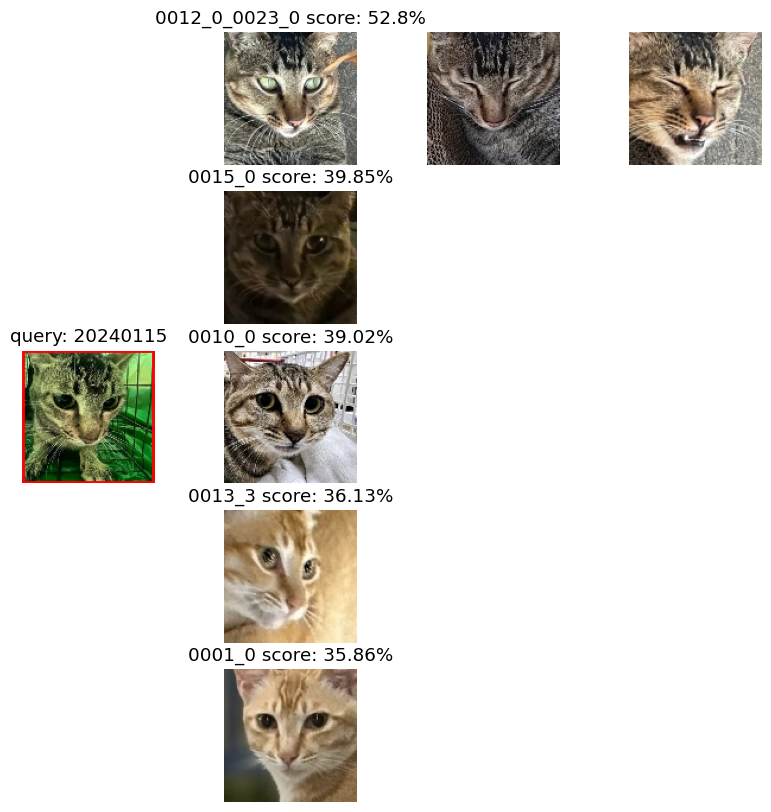

In [77]:
import matplotlib.patches as patches

%matplotlib inline

query_name = src.split('/')[-1]
db_path = f'UM_cat_dataset/um_cat_alignment_split'

for k, v in json_data.items():
    print(f'{k}:\t{v}')

img_num = max(len(test_imgs), max([len(os.listdir(f'{db_path}/{f}')) for f in top_n_pred])) + 1
img_num = min(img_num, 4)

plt.figure(figsize=(10, 10))
print('\nid\tdes')
for fig_col, (s, f) in enumerate(zip(top_n_cos, top_n_pred)):
    des = df[df['id'] == f]['description'].values[0]
    print(f'{f}:\t{des}')
    for i, img_name in enumerate(os.listdir(f'{db_path}/{f}')[:img_num-1]):
        plt.subplot(5, img_num, (fig_col*img_num) + i + 2)
        img = Image.open(f'{db_path}/{f}/{img_name}')
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title(f'{f} score: {round(s*100, 2)}%')

plt.subplot(5, img_num, img_num * 2 + 1)
plt.imshow(test_imgs[0][...,::-1])
plt.title(f'query: {query_name}')
plt.axis('off')

# 添加红色边框
border_color = 'red'
border_width = 2
bs1 = test_imgs[0].shape[0] - border_width
bs2 = test_imgs[0].shape[1] - border_width
rect = patches.Rectangle((0, 0), bs2, bs1, linewidth=border_width, edgecolor=border_color, facecolor='none')
plt.gca().add_patch(rect)

plt.show()

temp_id:	20240116BT1
cabin_id:	倉號：澳門市政狗房 - 貓倉27
capture_datestr:	9:30 PM 16/01/2024
capture_location:	大學大馬路
link:	https://www.iam.gov.mo/canil/c/catchcat/detail.aspx?id=3efc15c3-8082-4918-bf01-e1b8d37faa6e


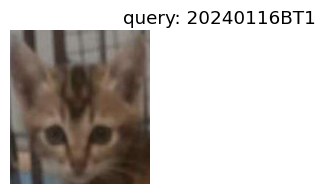

🇲🇴🏫🐈｜校園中流浪貓的小社群🐱 https://www.xiaohongshu.com/explore/6566047b000000003802d4b8


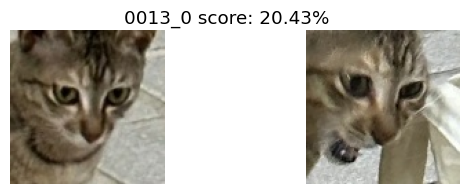

🇲🇴🏫🐈｜天冷冷，折手手 https://www.xiaohongshu.com/explore/658098a3000000000503808c


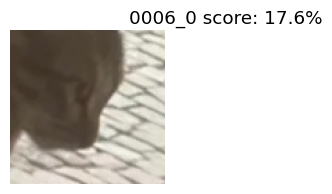

🇲🇴🏫🐈｜這裡有三隻好朋友 https://www.xiaohongshu.com/explore/659429f3000000000f011bdc


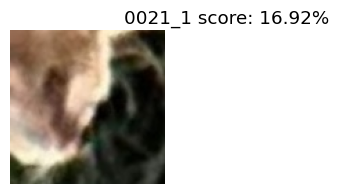

🇲🇴🏫🐈｜猜猜我是大眼仔還是大眼妹？https://www.xiaohongshu.com/explore/657b18ab000000000703aac2


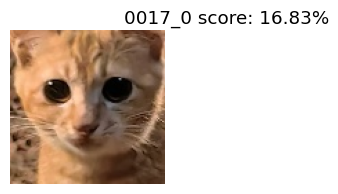

🇲🇴🏫🐈｜校園小角落裏的神袐小夥伴🕵🏻 https://www.xiaohongshu.com/explore/655cbf8a0000000032024052


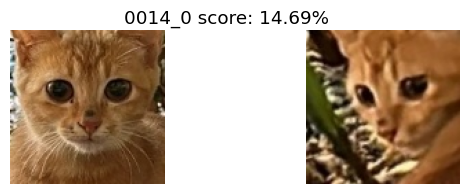

In [12]:
%matplotlib inline
query_name = src.split('/')[-1]
db_path = f'UM_cat_dataset/um_cat_alignment_split'

for k, v in json_data.items():
    print(f'{k}:\t{v}')

img_num = max(len(test_imgs), max([len(os.listdir(f'{db_path}/{f}')) for f in top_n_pred]))
plt.figure(figsize=(7, 2))
for i, img in enumerate(test_imgs):
    plt.subplot(1, img_num, i+1)
    plt.imshow(img[...,::-1])
    plt.axis('off')
plt.suptitle(f'query: {query_name}')
plt.show()

for s, f in zip(top_n_cos, top_n_pred):
    plt.figure(figsize=(7, 2))
    des = df[df['id'] == f]['description'].values[0]
    print(des)
    for i, img_name in enumerate(os.listdir(f'{db_path}/{f}')):
        plt.subplot(1, img_num, i+1)
        img = Image.open(f'{db_path}/{f}/{img_name}')
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'{f} score: {round(s*100, 2)}%')
    plt.show()
